# BESS-JPL Sensitivity Analysis with ECOv002 Cal-Val

This notebook performs a sensitivity analysis of the BESS-JPL model using ECOSTRESS Collection 2 Cal-Val data. It loads input data, processes it through the BESS-JPL model, and visualizes the impact of input perturbations on latent heat flux. The notebook also generates figures for publication and explores the relationship between surface temperature and latent heat flux.

## Import Required Libraries and Functions

This cell imports all necessary libraries and functions for data processing, model execution, statistical analysis, and plotting. It includes custom modules for the BESS-JPL model, sensitivity analysis, and net radiation calculations, as well as standard scientific Python libraries.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import verma_net_radiation_table
from ECOv003_L3T_L4T_JET import process_JET_table, load_ECOv002_calval_JET_inputs
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed, sensitivity_magnitude_barchart
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Configuration Options

Set configuration options for the notebook, including whether to save plots to files.

In [2]:
# Configuration: Set to True to save plots to files, False to only display them
SAVE_PLOTS = False

In [3]:
# we need to set limits on canopy height and elevation so that they're not perturbed into negative values

## Define Processing Function for Model Table

This cell defines the forward process for analysis as the BESS-JPL model.

In [4]:
forward_process = process_JET_table
model_name = "JET"

## Set Normalization Function

This cell assigns the normalization function used to compare perturbed model outputs to the unperturbed baseline. The function `divide_absolute_by_unperturbed` is used for normalization in the sensitivity analysis.

In [5]:
normalization_function = divide_absolute_by_unperturbed

## Load and Filter Input Data

This cell loads the ECOSTRESS Cal-Val input data using a custom loader function and filters out surface temperatures greater than 50 Celsius and NDVI values less than 0.05. The resulting DataFrame is displayed for inspection.

In [6]:
input_df = load_ECOv002_calval_JET_inputs()
input_df = input_df[input_df.ST_C <= 50]
input_df = input_df[input_df.NDVI.apply(lambda NDVI: NDVI > 0.05)]
input_df

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,CL,Tmin_open,Tmin_closed,VPD_open,VPD_closed,Tmin_C,Topt_C,fAPARmax,field_capacity,wilting_point
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,0.0070,12.02,-8.0,650.0,4500.0,32.65892,10.09,0.4659,0.24,0.11
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,0.0065,11.39,-8.0,650.0,3500.0,20.56636,1.39,0.4865,0.31,0.14
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,0.0065,11.39,-8.0,650.0,3500.0,20.56636,1.39,0.4865,0.31,0.14
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,0.0065,11.39,-8.0,650.0,3500.0,20.56636,1.39,0.4865,0.31,0.14
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,0.0065,11.39,-8.0,650.0,3500.0,20.56636,1.39,0.4865,0.31,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,NaN,NaN,NaN,NaN,NaN,NaN,7.99,0.3387,0.28,0.13
1061,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,NaN,NaN,NaN,NaN,NaN,NaN,7.99,0.3387,0.28,0.13
1062,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,NaN,NaN,NaN,NaN,NaN,NaN,7.99,0.3387,0.28,0.13
1063,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,NaN,NaN,NaN,NaN,NaN,NaN,7.99,0.3387,0.28,0.13


## Process Input Data Through Model

This cell applies the processing function to the filtered input data, running it through the model, and displays the resulting DataFrame.

In [7]:
processed = forward_process(input_df)
processed

[2026-01-29 11:09:04 INFO] starting JET table processing
[2026-01-29 11:09:04 INFO] started extracting geometry from JET input table
[2026-01-29 11:09:04 INFO] completed extracting geometry from JET input table (0.019 seconds)
[2026-01-29 11:09:04 INFO] started extracting time from JET input table
[2026-01-29 11:09:04 INFO] completed extracting time from JET input table (0.025 seconds)
[2026-01-29 11:09:04 INFO] running Forest Light Environmental Simulator
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[2026-01-29 11:09:04 INFO] completed processing FLiES-ANN in 0.21 seconds
[2026-01-29 11:09:04 INFO] variable PAR_albedo min: 0.003 mean: 0.050 max: 0.295 nan: 0.00% (nan)
[2026-01-29 11:09:04 INFO] variable NIR_albedo min: 0.028 mean: 0.162 max: 0.582 nan: 0.00% (nan)
[2026-01-29 11:09:04 INFO] variable PAR_direct_Wm2 min: 4.617 mean: 260.991 max: 450.882 nan: 0.39% (nan)
[2026-01-29 11:09:04 INFO] variable SWin_FLiES_ANN min: 104.662 mean: 703.378 max: 1147.278 nan: 0.39% (nan)
[2026-01-29 11

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,ET_daylight_PMJPL_kg,G_PMJPL_Wm2,G_Wm2,LE_instantaneous_Wm2,ET_daylight_kg,ET_uncertainty,GPP_inst_g_m2_s,ET_canopy_inst_kg_m2_s,WUE,AuxiliaryNWP
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,3.926174,60.425858,60.425858,351.448461,4.137355,0.772359,0.000212,0.000109,1.943556,
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,3.776037,99.328964,99.328964,326.039533,4.278552,1.239080,0.000269,0.000111,2.421845,
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,3.509339,94.519459,94.519459,335.227024,4.355584,0.920854,0.000251,0.000044,5.670131,
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,3.951882,78.277108,78.277108,332.815927,4.433988,0.372604,0.000303,0.000049,6.158837,
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,4.167672,70.628272,70.628272,290.934683,4.251193,0.369447,0.000283,0.000058,4.846558,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,0.077397,5.985288,5.985288,35.172955,0.423775,0.428256,0.000006,0.000008,0.723558,
1061,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,0.009217,23.006297,23.006297,37.569789,0.811693,1.321463,0.000015,0.000012,1.260016,
1062,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,0.000799,43.185134,43.185134,27.267393,0.584567,0.709445,0.000041,0.000031,1.332510,
1063,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,0.034415,28.164673,28.164673,58.151051,1.080137,0.608854,0.000024,0.000023,1.048858,


## Accuracy Comparison of In-Situ Observations to Model Estimates

Examining the accuracy of model estimates compared to ground data.

analyzing JET accuracy for ET_daylight_kg compared to insitu_ET_daylight_kg


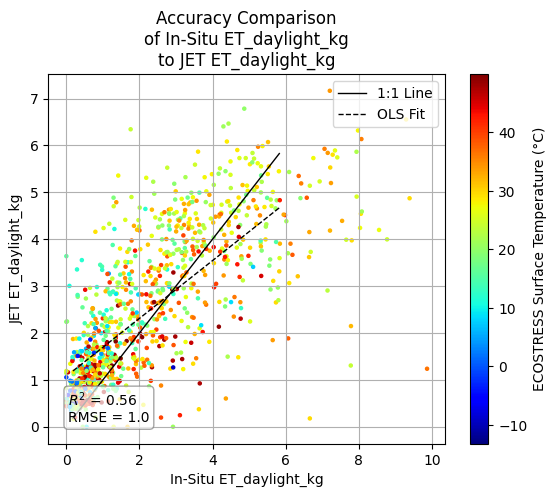

analyzing JET accuracy for G_Wm2 compared to insitu_G_Wm2


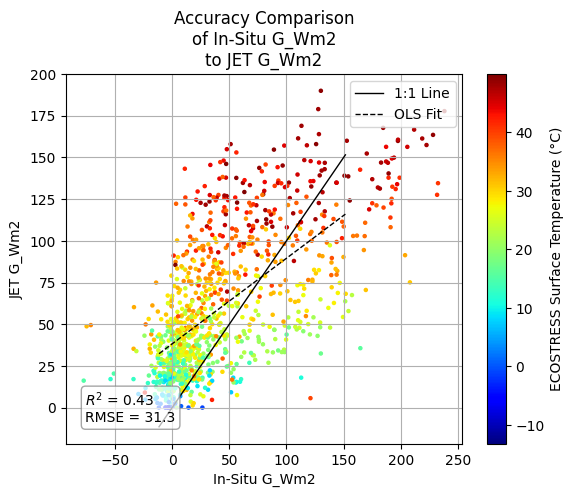

analyzing JET accuracy for H_Wm2 compared to insitu_H_Wm2


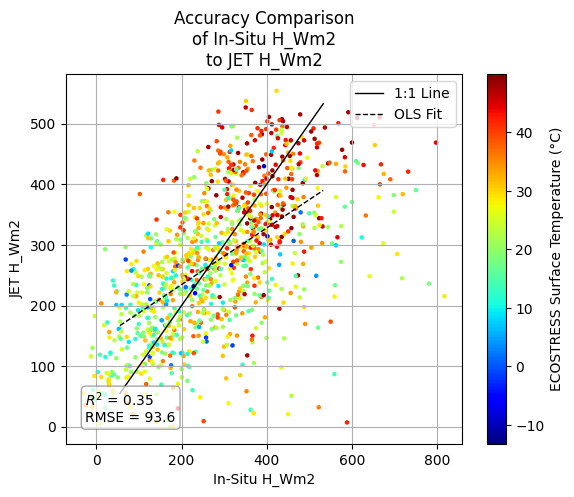

analyzing JET accuracy for LE_Wm2 compared to insitu_LE_Wm2


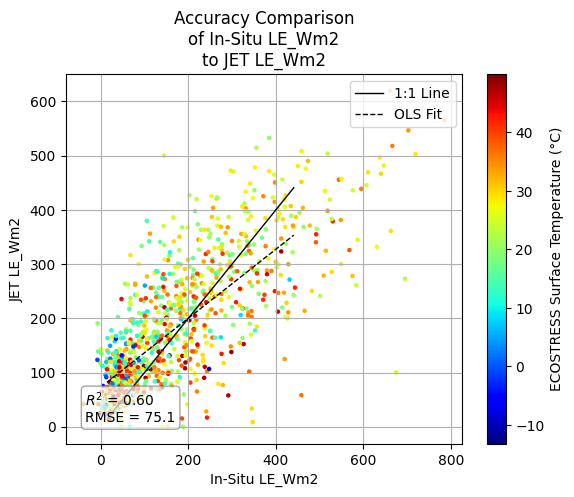

analyzing JET accuracy for LE_daylight_Wm2 compared to insitu_LE_daylight_Wm2
Error processing LE_daylight_Wm2: "['LE_daylight_Wm2'] not in index"
analyzing JET accuracy for Rn_Wm2 compared to insitu_Rn_Wm2


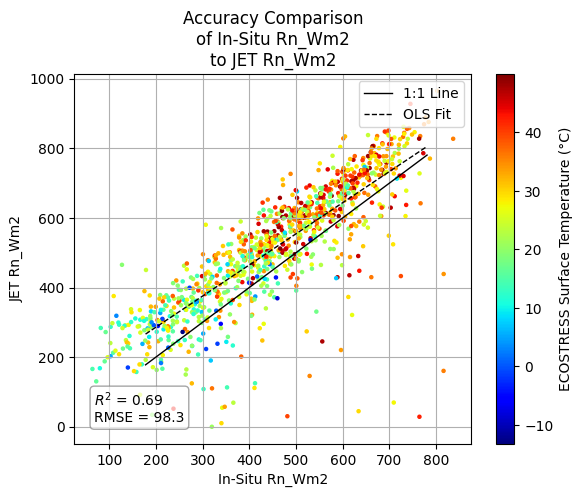

analyzing JET accuracy for Rn_daylight_Wm2 compared to insitu_Rn_daylight_Wm2
Error processing Rn_daylight_Wm2: "['Rn_daylight_Wm2'] not in index"
analyzing JET accuracy for SWin_Wm2 compared to insitu_SWin_Wm2


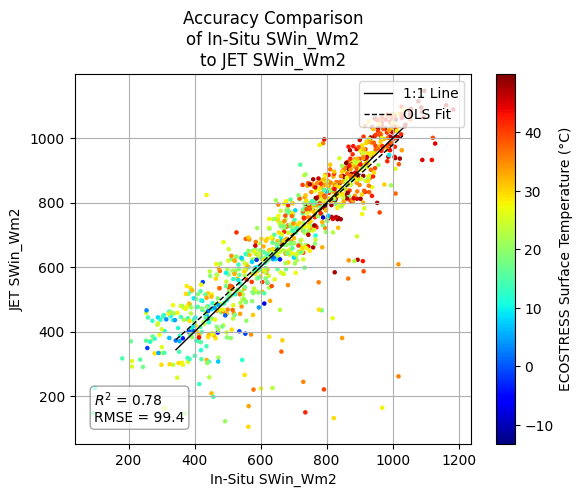

In [8]:
insitu_columns = sorted([column for column in processed.columns if "insitu" in column])

for insitu_variable in insitu_columns:
    try:
        variable = insitu_variable.replace("insitu_", "")
        print(f"analyzing {model_name} accuracy for {variable} compared to {insitu_variable}")
        
        x_variable = insitu_variable
        y_variable = variable

        # Filter out rows with NaN values in either variable
        valid_data = processed[[x_variable, y_variable, 'ST_C']].dropna()
        
        sc = plt.scatter(
            x=valid_data[x_variable],
            y=valid_data[y_variable],
            c=valid_data.ST_C,
            cmap="jet",
            color=None,
            s=5
        )

        # Calculate 5% and 95% tails for x and y variables
        x_5th, x_95th = np.percentile(valid_data[x_variable], [5, 95])
        y_5th, y_95th = np.percentile(valid_data[y_variable], [5, 95])

        min_val = min(x_5th, y_5th)
        max_val = max(x_95th, y_95th)

        # Add 1-to-1 line
        # min_val = min(valid_data[x_variable].min(), valid_data[y_variable].min())
        # max_val = max(valid_data[x_variable].max(), valid_data[y_variable].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

        # Add OLS regression line
        coefs = np.polyfit(valid_data[x_variable], valid_data[y_variable], 1)
        ols_x = np.array([min_val, max_val])
        ols_y = coefs[0] * ols_x + coefs[1]
        plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

        # Calculate R-squared and RMSE
        from sklearn.metrics import r2_score, mean_squared_error
        y_true = valid_data[y_variable]
        y_pred = coefs[0] * valid_data[x_variable] + coefs[1]
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Annotate R-squared and RMSE on plot in lower left corner
        plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    ha='left', va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

        # Set ticks every 100 for both axes
        # xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # plt.xticks(xticks)
        # plt.yticks(yticks)

        plt.grid(True, zorder=0) 
        plt.xlabel(f"In-Situ {variable}")
        plt.ylabel(f"{model_name} {variable}")
        plt.title(f"Accuracy Comparison\nof In-Situ {variable}\nto {model_name} {variable}")
        plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
        plt.legend(loc='upper right')
        
        if SAVE_PLOTS:
            plt.savefig(f"Accuracy Comparison of In-Situ {variable} to {model_name} {variable}.jpeg", format='jpeg', bbox_inches='tight')
            plt.savefig(f"Accuracy Comparison of In-Situ {variable} to {model_name} {variable}.svg", format='svg', bbox_inches='tight')
        
        plt.show()
    except Exception as e:
        print(f"Error processing {variable}: {e}")
        continue

## Plot Unperturbed Comparison of Surface Temperature to Net Radiation

This cell creates a scatter plot comparing ECOSTRESS surface temperature to net radiation for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

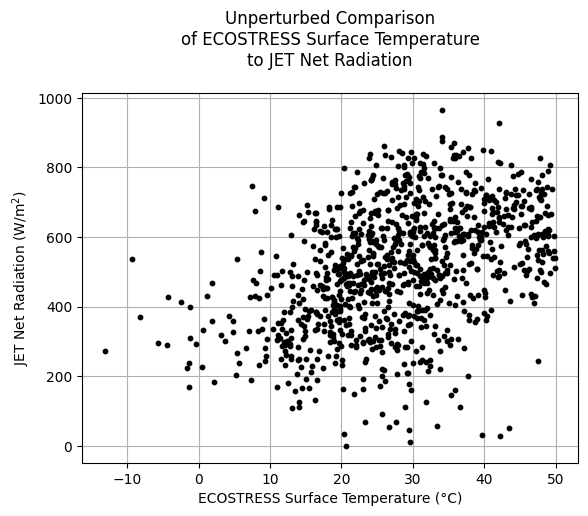

In [9]:
plt.scatter(x=processed.ST_C, y=processed.Rn_Wm2, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel(f"{model_name} Net Radiation (W/m$^2$)")
plt.title(f"Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto {model_name} Net Radiation", pad=20)

if SAVE_PLOTS:
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Net Radiation.jpeg", format='jpeg', bbox_inches='tight')
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Net Radiation.svg", format='svg', bbox_inches='tight')

plt.show()

## Plot Unperturbed Comparison of Surface Temperature to Evapotranspiration

This cell creates a scatter plot comparing ECOSTRESS surface temperature to BESS-JPL evapotranspiration for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

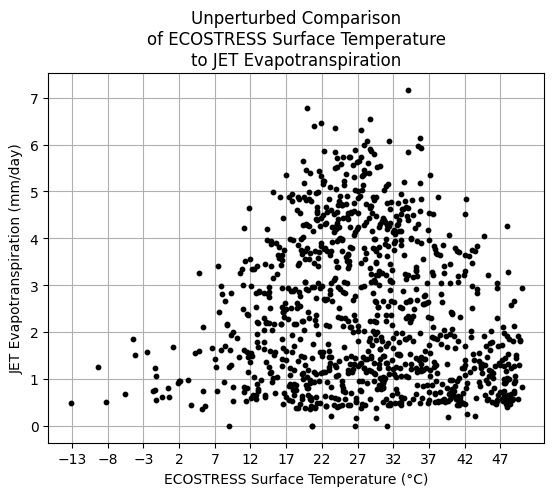

In [10]:
plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
plt.scatter(x=processed.ST_C, y=processed.ET_daylight_kg, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel(f"{model_name} Evapotranspiration (mm/day)")
plt.title(f"Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto {model_name} Evapotranspiration")

if SAVE_PLOTS:
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Evapotranspiration.jpeg", format='jpeg', bbox_inches='tight')
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Evapotranspiration.svg", format='svg', bbox_inches='tight')

plt.show()

## Check Number of Valid Input Rows

This cell displays the number of rows remaining in the input DataFrame after all filtering steps, confirming the size of the dataset used for analysis.

In [11]:
len(input_df)

1019

## Perturbed Model Analysis for Net Radiation

In [12]:
input_variable = "ST_C"
output_variable = "Rn_Wm2"

Rn_results = perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_JET_table,
    normalization_function=normalization_function
)

Rn_results

[2026-01-29 11:09:05 INFO] Starting Monte Carlo perturbed run
[2026-01-29 11:09:05 INFO] calculating standard deviation of input variable: ST_C
[2026-01-29 11:09:05 INFO] input variable ST_C standard deviation: 11.251614530435507
[2026-01-29 11:09:05 INFO] starting forward process
[2026-01-29 11:09:05 INFO] starting JET table processing
[2026-01-29 11:09:05 INFO] started extracting geometry from JET input table
[2026-01-29 11:09:05 INFO] completed extracting geometry from JET input table (0.017 seconds)
[2026-01-29 11:09:05 INFO] started extracting time from JET input table
[2026-01-29 11:09:05 INFO] completed extracting time from JET input table (0.025 seconds)
[2026-01-29 11:09:05 INFO] running Forest Light Environmental Simulator
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[2026-01-29 11:09:06 INFO] completed processing FLiES-ANN in 0.18 seconds
[2026-01-29 11:09:06 INFO] variable PAR_albedo min: 0.003 mean: 0.050 max: 0.295 nan: 0.00% (nan)
[2026-01-29 11:09:06 INFO] variable NIR_albed

,input_variable,output_variable,input_unperturbed,input_perturbation,input_perturbation_std,input_perturbed,output_unperturbed,output_perturbation,output_perturbation_std,output_perturbed
0,ST_C,Rn_Wm2,31.95,-3.324507,0.104053,28.625493,466.636092,19.972323,0.042801,486.608415
1,ST_C,Rn_Wm2,31.95,-0.165935,0.005194,31.784065,466.636092,1.012485,0.00217,467.648577
2,ST_C,Rn_Wm2,31.95,7.022032,0.219782,38.972032,466.636092,-44.384646,0.095116,422.251445
3,ST_C,Rn_Wm2,31.95,-9.800435,0.306743,22.149565,466.636092,57.025841,0.122206,523.661932
4,ST_C,Rn_Wm2,31.95,-2.539654,0.079488,29.410346,466.636092,15.316317,0.032823,481.952409
...,...,...,...,...,...,...,...,...,...,...
101895,ST_C,Rn_Wm2,41.61,-19.283649,0.463438,22.326351,701.213404,121.628947,0.173455,822.842351
101896,ST_C,Rn_Wm2,41.61,12.270993,0.294905,53.880993,701.213404,-89.978625,0.128318,611.234779
101897,ST_C,Rn_Wm2,41.61,-14.863704,0.357215,26.746296,701.213404,95.763051,0.136568,796.976455
101898,ST_C,Rn_Wm2,41.61,-6.877434,0.165283,34.732566,701.213404,46.03794,0.065655,747.251343


## Perturbed Model Analysis for Evapotranspiration

In [13]:
input_variable = "ST_C"
output_variable = "ET_daylight_kg"

ET_results = perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=forward_process,
    normalization_function=normalization_function
)

ET_results = ET_results.dropna()

ET_results

[2026-01-29 11:09:43 INFO] Starting Monte Carlo perturbed run
[2026-01-29 11:09:43 INFO] calculating standard deviation of input variable: ST_C
[2026-01-29 11:09:43 INFO] input variable ST_C standard deviation: 11.251614530435507
[2026-01-29 11:09:43 INFO] starting forward process
[2026-01-29 11:09:43 INFO] starting JET table processing
[2026-01-29 11:09:43 INFO] started extracting geometry from JET input table
[2026-01-29 11:09:43 INFO] completed extracting geometry from JET input table (0.016 seconds)
[2026-01-29 11:09:43 INFO] started extracting time from JET input table
[2026-01-29 11:09:43 INFO] completed extracting time from JET input table (0.024 seconds)
[2026-01-29 11:09:43 INFO] running Forest Light Environmental Simulator
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[2026-01-29 11:09:43 INFO] completed processing FLiES-ANN in 0.17 seconds
[2026-01-29 11:09:43 INFO] variable PAR_albedo min: 0.003 mean: 0.050 max: 0.295 nan: 0.00% (nan)
[2026-01-29 11:09:43 INFO] variable NIR_albed

,input_variable,output_variable,input_unperturbed,input_perturbation,input_perturbation_std,input_perturbed,output_unperturbed,output_perturbation,output_perturbation_std,output_perturbed
0,ST_C,ET_daylight_kg,31.95,10.406915,0.325725,42.356915,4.137355,-1.063015,0.256931,3.074340
1,ST_C,ET_daylight_kg,31.95,-13.146110,0.411459,18.80389,4.137355,-0.209789,0.050706,3.927567
2,ST_C,ET_daylight_kg,31.95,-7.479825,0.234110,24.470175,4.137355,-0.568099,0.13731,3.569257
3,ST_C,ET_daylight_kg,31.95,0.787581,0.024650,32.737581,4.137355,-0.076899,0.018587,4.060456
4,ST_C,ET_daylight_kg,31.95,-8.681283,0.271715,23.268717,4.137355,0.30839,0.074538,4.445745
...,...,...,...,...,...,...,...,...,...,...
101895,ST_C,ET_daylight_kg,41.61,2.851257,0.068523,44.461257,1.230464,-0.060236,0.048954,1.170228
101896,ST_C,ET_daylight_kg,41.61,22.561990,0.542225,64.17199,1.230464,-0.497071,0.40397,0.733393
101897,ST_C,ET_daylight_kg,41.61,-8.900201,0.213896,32.709799,1.230464,0.292721,0.237895,1.523185
101898,ST_C,ET_daylight_kg,41.61,-5.710140,0.137230,35.89986,1.230464,0.210727,0.171258,1.441191


## Plot Change in Surface Temperature vs Net Radiation

This cell generates a scatter plot showing the relationship between changes in surface temperature and changes in BESS-JPL net radiation due to input perturbations. The plot is saved as JPEG and SVG files.

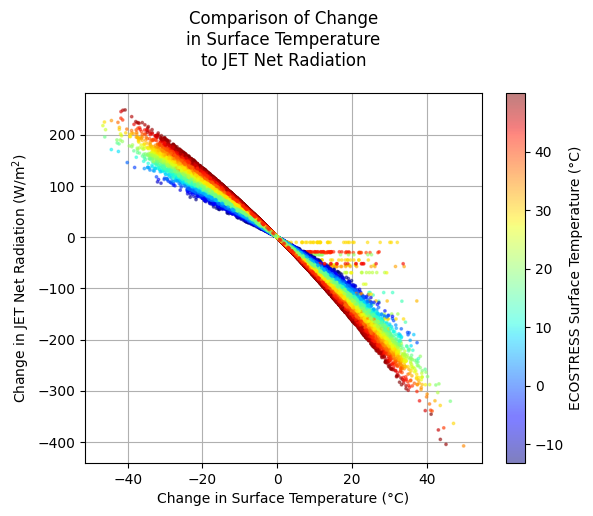

In [14]:
sc = plt.scatter(
    x=Rn_results.input_perturbation, 
    y=Rn_results.output_perturbation, 
    c=Rn_results.input_unperturbed, 
    color=None,
    cmap="jet",
    s=3,
    alpha=0.5, 
    zorder=5
)

plt.grid(True, zorder=0)
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel(f"Change in {model_name} Net Radiation (W/m$^2$)")
plt.title(f"Comparison of Change\nin Surface Temperature\nto {model_name} Net Radiation", pad=20)
plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")

if SAVE_PLOTS:
    plt.savefig(f"Comparison of Change in Surface Temperature to {model_name} Net Radiation.jpeg", format='jpeg', bbox_inches='tight')
    plt.savefig(f"Comparison of Change in Surface Temperature to {model_name} Net Radiation.svg", format='svg', bbox_inches='tight')

plt.show()

## Plot Change in Surface Temperature vs Evapotranspiration

This cell generates a scatter plot showing the relationship between changes in surface temperature and changes in evapotranspiration due to input perturbations. The plot is saved as JPEG and SVG files.

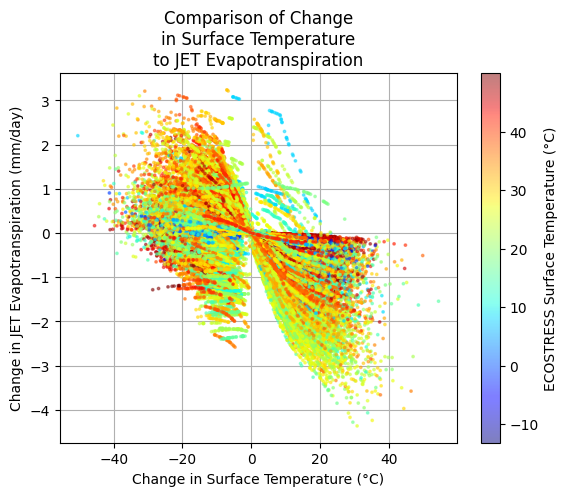

In [15]:
sc = plt.scatter(
    x=ET_results.input_perturbation, 
    y=ET_results.output_perturbation, 
    c=ET_results.input_unperturbed, 
    color=None,
    cmap="jet",
    s=3,
    alpha=0.5, 
    zorder=5
)

plt.grid(True, zorder=0)
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel(f"Change in {model_name} Evapotranspiration (mm/day)")
plt.title(f"Comparison of Change\nin Surface Temperature\nto {model_name} Evapotranspiration")
plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")

if SAVE_PLOTS:
    plt.savefig(f"Comparison of Change in Surface Temperature to {model_name} Evapotranspiration.jpeg", format='jpeg', bbox_inches='tight')
    plt.savefig(f"Comparison of Change in Surface Temperature to {model_name} Evapotranspiration.svg", format='svg', bbox_inches='tight')

plt.show()

## Run Full Sensitivity Analysis for Multiple Inputs

This cell performs a comprehensive sensitivity analysis by perturbing several input variables (surface temperature, NDVI, albedo, air temperature, relative humidity) and measuring their effect on latent heat flux. The results are summarized in a DataFrame.

In [16]:
input_variables = [
    "ST_C",
    "NDVI",
    "albedo",
    "Ta_C",
    "RH",
    "AOT",
    "COT",
    "vapor_gccm",
    "ozone_cm",
    "elevation_m",
    "canopy_height_meters"
]

output_variables = [
    "Rn_Wm2",
    "ET_daylight_kg",
    "GPP_inst_g_m2_s"
]

perturbation_df, sensitivity_metrics_df = sensitivity_analysis(
    input_df=input_df,
    input_variables=input_variables,
    output_variables=output_variables,
    forward_process=process_JET_table,
    normalization_function=normalization_function,
    use_joint_run=True  # Explicitly enable joint run mode
)

sensitivity_metrics_df

[2026-01-29 11:10:21 INFO] starting JET table processing
[2026-01-29 11:10:21 INFO] started extracting geometry from JET input table
[2026-01-29 11:10:21 INFO] completed extracting geometry from JET input table (0.016 seconds)
[2026-01-29 11:10:21 INFO] started extracting time from JET input table
[2026-01-29 11:10:21 INFO] completed extracting time from JET input table (0.024 seconds)
[2026-01-29 11:10:21 INFO] running Forest Light Environmental Simulator
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[2026-01-29 11:10:21 INFO] completed processing FLiES-ANN in 0.18 seconds
[2026-01-29 11:10:21 INFO] variable PAR_albedo min: 0.003 mean: 0.050 max: 0.295 nan: 0.00% (nan)
[2026-01-29 11:10:21 INFO] variable NIR_albedo min: 0.028 mean: 0.162 max: 0.582 nan: 0.00% (nan)
[2026-01-29 11:10:21 INFO] variable PAR_direct_Wm2 min: 4.617 mean: 260.991 max: 450.882 nan: 0.00% (nan)
[2026-01-29 11:10:21 INFO] variable SWin_FLiES_ANN min: 104.662 mean: 703.378 max: 1147.278 nan: 0.00% (nan)
[2026-01-29 11

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/BESS_JPL/meteorology.py:394: RuntimeWarning: invalid value encountered in sqrt
  epsa0 = 0.605 + 0.048 * (Ea_Pa / 100) ** 0.5  # Clear-sky emissivity


[2026-01-29 11:13:02 INFO] variable desTa min: 2.013 mean: 172.957 max: 1082.690 nan: 0.00% (nan)
[2026-01-29 11:13:02 INFO] variable ddesTa min: 0.191 mean: 8.995 max: 41.671 nan: 0.00% (nan)
[2026-01-29 11:13:02 INFO] variable gamma min: 33.560 mean: 60.275 max: 86.585 nan: 0.00% (nan)
[2026-01-29 11:13:02 INFO] variable Cp min: 1001.743 mean: 1012.742 max: 1094.710 nan: 0.00% (nan)
[2026-01-29 11:13:03 INFO] variable rhoa min: 0.615 mean: 1.070 max: 1.613 nan: 0.00% (nan)
[2026-01-29 11:13:03 INFO] variable epsa min: 0.607 mean: 0.776 max: 1.125 nan: 0.02% (nan)
[2026-01-29 11:13:03 INFO] variable R min: 4.936 mean: 104.511 max: 1000.000 nan: 0.20% (nan)
[2026-01-29 11:13:03 INFO] variable Rc min: 4.936 mean: 104.511 max: 1000.000 nan: 0.20% (nan)
[2026-01-29 11:13:03 INFO] variable Rs min: 2.468 mean: 52.255 max: 500.000 nan: 0.20% (nan)
[2026-01-29 11:13:03 INFO] variable SFd min: 0.020 mean: 0.051 max: 0.083 nan: 0.00% (nan)
[2026-01-29 11:13:03 INFO] variable SFd2 min: 0.157 mea

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/BESS_JPL/LAI_from_NDVI.py:26: RuntimeWarning: divide by zero encountered in log
  LAI = rt.clip(-np.log(1 - fIPAR) * (1 / KPAR), min_LAI, max_LAI)


[2026-01-29 11:13:03 INFO] variable PARDiff min: 0.000 mean: 51.487 max: 256.842 nan: 0.00% (nan)
[2026-01-29 11:13:03 INFO] variable PARDir min: 2.944 mean: 255.426 max: 514.019 nan: 0.00% (nan)
[2026-01-29 11:13:03 INFO] variable NIRDiff min: 0.000 mean: 40.746 max: 415.300 nan: 0.00% (nan)
[2026-01-29 11:13:03 INFO] variable NIRDir min: 0.000 mean: 309.441 max: 607.142 nan: 0.00% (nan)
[2026-01-29 11:13:03 INFO] variable UV min: 4.907 mean: 41.028 max: 77.947 nan: 0.00% (nan)
[2026-01-29 11:13:03 INFO] variable SZA min: 9.246 mean: 45.817 max: 72.288 nan: 0.00% (nan)
[2026-01-29 11:13:03 INFO] variable LAI min: 0.020 mean: 1.386 max: 10.000 nan: 1.15% (nan)
[2026-01-29 11:13:03 INFO] variable CI min: 0.184 mean: 0.279 max: 1.000 nan: 0.00% (nan)
[2026-01-29 11:13:03 INFO] variable albedo_visible min: 0.003 mean: 0.050 max: 0.295 nan: 0.00% (nan)
[2026-01-29 11:13:03 INFO] variable albedo_NIR min: 0.028 mean: 0.162 max: 0.582 nan: 0.00% (nan)
[2026-01-29 11:13:03 INFO] variable kb mi

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/BESS_JPL/canopy_energy_balance.py:70: RuntimeWarning: divide by zero encountered in divide
  Ci = Ca - 1.6 * An / gs1  # [umol./mol]
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/BESS_JPL/canopy_energy_balance.py:76: RuntimeWarning: divide by zero encountered in divide
  rs = 1.0 / (gs1 / cf * 1e-2)  # [s m-1]


[2026-01-29 11:13:06 INFO] variable GPP_C3 min: 0.000 mean: 9.442 max: 40.000 nan: 1.15% (nan)
[2026-01-29 11:13:06 INFO] variable LE_C3 min: 0.000 mean: 114.992 max: 964.977 nan: 0.00% (nan)
[2026-01-29 11:13:06 INFO] variable LE_soil_C3 min: 0.000 mean: 52.307 max: 384.228 nan: 0.00% (nan)
[2026-01-29 11:13:06 INFO] variable LE_canopy_C3 min: 0.000 mean: 62.685 max: 944.648 nan: 0.00% (nan)
[2026-01-29 11:13:06 INFO] variable Rn_C3 min: 0.000 mean: 447.334 max: 1000.000 nan: 0.00% (nan)
[2026-01-29 11:13:06 INFO] variable Rn_soil_C3 min: 0.000 mean: 331.075 max: 926.246 nan: 0.00% (nan)
[2026-01-29 11:13:06 INFO] variable Rn_canopy_C3 min: 0.000 mean: 116.701 max: 1127.173 nan: 0.00% (nan)


/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/BESS_JPL/canopy_energy_balance.py:70: RuntimeWarning: invalid value encountered in divide
  Ci = Ca - 1.6 * An / gs1  # [umol./mol]


[2026-01-29 11:13:07 INFO] variable GPP_C4 min: 0.000 mean: 13.789 max: 50.000 nan: 1.15% (nan)
[2026-01-29 11:13:07 INFO] variable LE_C4 min: 0.000 mean: 116.739 max: 967.767 nan: 0.00% (nan)
[2026-01-29 11:13:07 INFO] variable LE_soil_C4 min: 0.000 mean: 52.307 max: 384.228 nan: 0.00% (nan)
[2026-01-29 11:13:07 INFO] variable LE_canopy_C4 min: 0.000 mean: 64.432 max: 947.438 nan: 0.00% (nan)
[2026-01-29 11:13:07 INFO] variable Rn_C4 min: 0.000 mean: 447.334 max: 1000.000 nan: 0.00% (nan)
[2026-01-29 11:13:07 INFO] variable Rn_soil_C4 min: 0.000 mean: 331.075 max: 926.246 nan: 0.00% (nan)
[2026-01-29 11:13:07 INFO] variable Rn_canopy_C4 min: 0.000 mean: 116.701 max: 1127.173 nan: 0.00% (nan)
[2026-01-29 11:13:07 INFO] started daylight ET upscaling
[2026-01-29 11:13:44 INFO] completed daylight ET upscaling (elapsed: 36.58 seconds)
[2026-01-29 11:13:44 INFO] completed processing BESS-JPL in 89.43 seconds
[2026-01-29 11:13:44 INFO] variable Rn_BESS_Wm2 min: 0.000 mean: 447.334 max: 1000.

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/STIC_JPL/LAI_from_NDVI.py:59: RuntimeWarning: divide by zero encountered in log
  LAI = rt.clip(-np.log(1 - fIPAR) * (1 / KPAR), min_LAI, max_LAI)


[2026-01-29 11:14:46 INFO] running STIC iteration 1 / 3
[2026-01-29 11:14:47 INFO] using variable Priestley-Taylor alpha with mean: 1.331
[2026-01-29 11:14:47 INFO] completed STIC iteration 1 / 3 with max LE change: 2364.197 (0.12319475000003877 seconds)
[2026-01-29 11:14:47 INFO] variable SM_1 min: 0.000 mean: 0.148 max: 1.000 nan: 0.00% (nan)
[2026-01-29 11:14:47 INFO] variable G_1 min: -0.000 mean: 59.273 max: 240.767 nan: 1.15% (nan)
[2026-01-29 11:14:47 INFO] variable LE_1 min: -390.327 mean: 239.479 max: 982.799 nan: 1.15% (nan)
[2026-01-29 11:14:47 INFO] running STIC iteration 2 / 3
[2026-01-29 11:14:47 INFO] using variable Priestley-Taylor alpha with mean: 1.938
[2026-01-29 11:14:47 INFO] completed STIC iteration 2 / 3 with max LE change: 664.425 (0.45347995799966156 seconds)
[2026-01-29 11:14:47 INFO] variable SM_2 min: 0.000 mean: 0.151 max: 1.000 nan: 0.00% (nan)
[2026-01-29 11:14:47 INFO] variable G_2 min: -0.000 mean: 59.273 max: 240.767 nan: 1.15% (nan)
[2026-01-29 11:14:

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/carlson_leaf_area_index/carlson_leaf_area_index.py:66: RuntimeWarning: divide by zero encountered in log
  LAI = rt.clip(-np.log(1 - fIPAR) * (1 / KPAR), min_LAI, max_LAI)  # Beer-Lambert law for canopy


[2026-01-29 11:15:25 INFO] variable Rn_canopy_Wm2 min: 0.000 mean: 243.072 max: 979.833 nan: 1.15% (nan)
[2026-01-29 11:15:25 INFO] variable PET min: 0.000 mean: 398.103 max: 1263.428 nan: 1.15% (nan)
[2026-01-29 11:15:25 INFO] variable fTRM min: 0.000 mean: 0.809 max: 1.000 nan: 1.15% (nan)
[2026-01-29 11:15:25 INFO] variable LE_canopy_Wm2 min: 0.000 mean: 152.710 max: 844.479 nan: 1.15% (nan)


/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/PTJPLSM/partitioning/fTRM.py:27: RuntimeWarning: invalid value encountered in sqrt
  CHscalar = np.sqrt(canopy_height_meters)


[2026-01-29 11:15:25 INFO] variable LE_interception_Wm2 min: 0.000 mean: 13.425 max: 647.321 nan: 1.15% (nan)
[2026-01-29 11:15:26 INFO] variable LE_Wm2 min: 0.000 mean: 229.489 max: 968.473 nan: 1.15% (nan)
[2026-01-29 11:15:26 INFO] started daylight ET upscaling
[2026-01-29 11:16:10 INFO] completed daylight ET upscaling (elapsed: 44.73 seconds)
[2026-01-29 11:16:10 INFO] PT-JPL-SM model run complete (elapsed: 45.88 seconds)
[2026-01-29 11:16:10 INFO] completed processing PT-JPL-SM in 45.88 seconds
[2026-01-29 11:16:10 INFO] variable LE_PTJPLSM_Wm2 min: 0.000 mean: 229.489 max: 968.473 nan: 1.15% (nan)
[2026-01-29 11:16:10 INFO] variable ET_daylight_PTJPLSM_kg min: 0.000 mean: 3.099 max: 12.755 nan: 1.15% (nan)
[2026-01-29 11:16:10 INFO] variable G_PTJPLSM min: -0.000 mean: 59.273 max: 240.767 nan: 1.15% (nan)
[2026-01-29 11:16:11 INFO] variable EF_PTJPLSM min: 0.000 mean: 0.493 max: 1.160 nan: 1.15% (nan)
[2026-01-29 11:16:11 INFO] variable LE_canopy_PTJPLSM_Wm2 min: 0.000 mean: 152.

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/carlson_leaf_area_index/carlson_leaf_area_index.py:66: RuntimeWarning: divide by zero encountered in log
  LAI = rt.clip(-np.log(1 - fIPAR) * (1 / KPAR), min_LAI, max_LAI)  # Beer-Lambert law for canopy


[2026-01-29 11:16:12 INFO] variable delta_Pa min: 2.029 mean: 172.617 max: 1077.849 nan: 0.00% (nan)
[2026-01-29 11:16:12 INFO] variable fwet min: 0.000 mean: 0.018 max: 2.749 nan: 0.00% (nan)
[2026-01-29 11:16:12 INFO] calculating PM-MOD resistances
[2026-01-29 11:16:12 INFO] variable gl_sh (float32) with [0.01 0.02 0.04 0.08] unique values
[2026-01-29 11:16:12 INFO] * 0.01: 144100
[2026-01-29 11:16:12 INFO] * 0.02: 522500
[2026-01-29 11:16:12 INFO] * 0.04: 289300
[2026-01-29 11:16:12 INFO] * 0.08: 160600
[2026-01-29 11:16:12 INFO] variable rhc min: 2.009 mean: 1926.091 max: 2000.000 nan: 1.15% (nan)
[2026-01-29 11:16:12 INFO] variable rrc min: 125.905 mean: 238.266 max: 591.492 nan: 0.00% (nan)
[2026-01-29 11:16:12 INFO] variable rhrc min: 1.993 mean: 206.219 max: 456.488 nan: 1.15% (nan)
[2026-01-29 11:16:12 INFO] variable gl_e_wv (float32) with [0.01 0.02 0.04 0.08] unique values
[2026-01-29 11:16:12 INFO] * 0.01: 144100
[2026-01-29 11:16:12 INFO] * 0.02: 522500
[2026-01-29 11:16:1

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/PMJPL/soil_moisture_constraint.py:19: RuntimeWarning: invalid value encountered in power
  return RH ** (VPD / beta)


[2026-01-29 11:16:57 INFO] completed daylight ET upscaling (PMJPL)
[2026-01-29 11:16:57 INFO] completed processing PM-JPL in 46.27 seconds
[2026-01-29 11:16:57 INFO] variable LE_PMJPL_Wm2 min: 0.000 mean: 139.090 max: 850.925 nan: 1.15% (nan)
[2026-01-29 11:16:58 INFO] variable ET_daylight_PMJPL_kg min: 0.000 mean: 1.931 max: 11.362 nan: 1.15% (nan)
[2026-01-29 11:16:58 INFO] variable G_PMJPL_Wm2 min: -0.000 mean: 59.273 max: 240.767 nan: 1.15% (nan)
[2026-01-29 11:16:58 INFO] variable ET_daylight_kg min: 0.000 mean: 2.373 max: 10.761 nan: 0.00% (nan)
[2026-01-29 11:17:00 INFO] JET table processing complete (397.362 seconds)


,input_variable,output_variable,metric,value
0,ST_C,Rn_Wm2,correlation,0.077038
1,ST_C,Rn_Wm2,r2,0.005935
2,ST_C,Rn_Wm2,mean_normalized_change,0.129164
3,NDVI,Rn_Wm2,correlation,NaN
4,NDVI,Rn_Wm2,r2,NaN
...,...,...,...,...
94,elevation_m,GPP_inst_g_m2_s,r2,0.000821
95,elevation_m,GPP_inst_g_m2_s,mean_normalized_change,0.015858
96,canopy_height_meters,GPP_inst_g_m2_s,correlation,NaN
97,canopy_height_meters,GPP_inst_g_m2_s,r2,NaN


## Plot Sensitivity Magnitude Bar Chart

This cell creates a bar chart showing the average percent change in latent heat flux for each input variable, visualizing the magnitude of model sensitivity to each input.

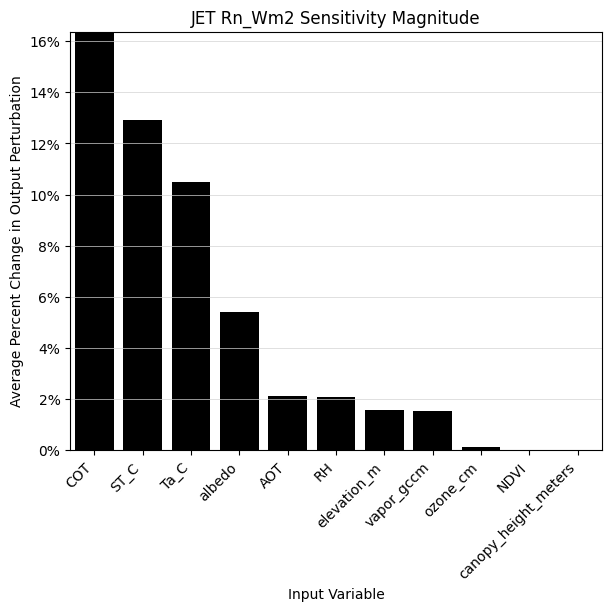

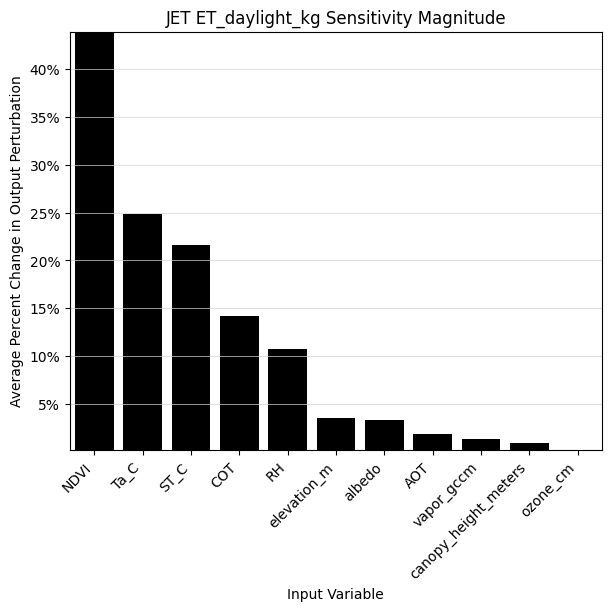

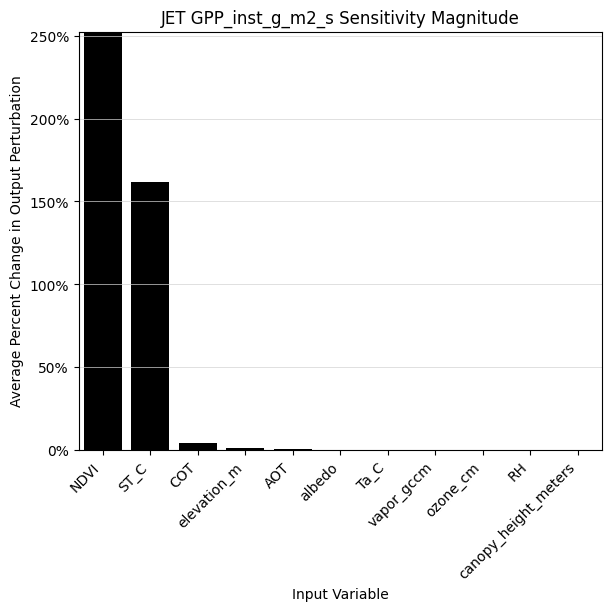

In [17]:
for output_variable in output_variables:
    sensitivity_magnitude_barchart(
        model_name=model_name,
        output_variable=output_variable,
        df=sensitivity_metrics_df
    )

## Summary and Next Steps

This notebook demonstrated a full sensitivity analysis workflow for the BESS-JPL model using ECOSTRESS Cal-Val data. Key results include the identification of input variables with the greatest influence on latent heat flux. Next steps could include further exploration of model parameters, additional visualizations, or application to other datasets.